alpha:  22783538667135.83


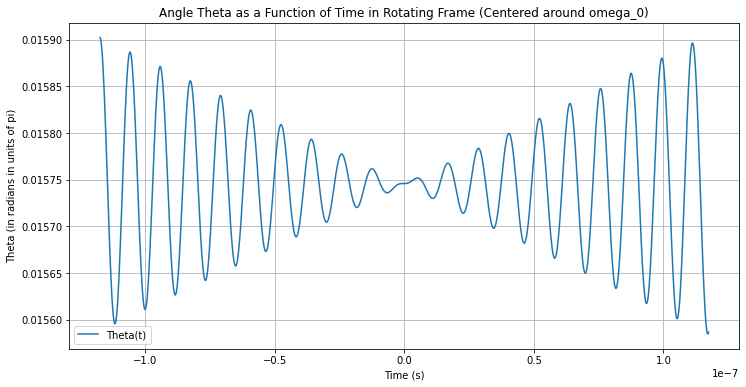

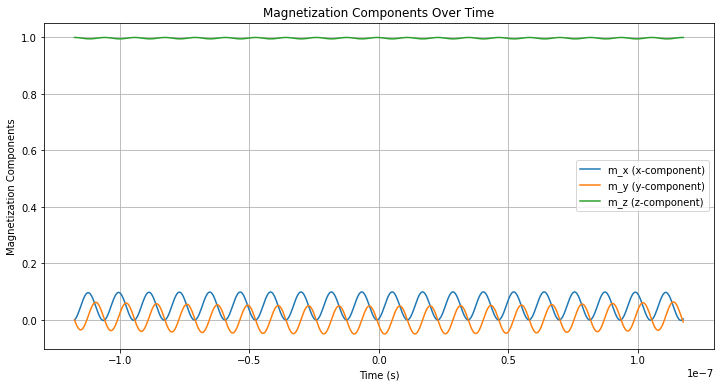

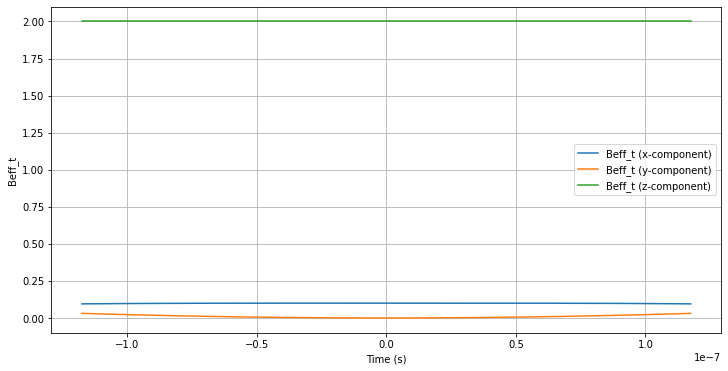

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Constants for proton
gamma = 2 * np.pi * 42.58e6  # gyromagnetic ratio for protons (rad/s/T)
B0 = 1  # static field strength in T
B1 = 0.1  # oscillating field magnitude in T
omega_0 = gamma * B0  # resonance frequency for static field B0

# Parameters for the frequency sweep
Delta_omega = omega_0 / 100  # Sweep range around omega_0
sweep_time = 10 * (2 * np.pi / omega_0)  # Total time of 10 Larmor periods
alpha = Delta_omega / (sweep_time / 2)  # rate of frequency change

print("alpha: ", alpha)

# Equation of motion in the rotating frame
def rotating_frame_eq_centered_omega(t, m):
    # Symmetric frequency sweep around omega_0
    omega_t = alpha * t
    Beff_x = B1 * np.cos(omega_t * t)
    Beff_y = B1 * np.sin(omega_t * t)
    Beff_z = B0 + omega_0 / gamma  # Corrected sign according to the rotating frame reference
    Beff = np.array([Beff_x, Beff_y, Beff_z])
    
    # LLG equation in the rotating frame
    dm_dt = -gamma * np.cross(m, Beff)
    return dm_dt

# Initial condition - spin aligned with z-axis
m0 = np.array([0, 0, 1])

# Time span for the simulation, centered around 0
t_span = (-sweep_time / 2, sweep_time / 2)

# Solve the LLG equation in the rotating frame with the corrected effective field
sol = solve_ivp(
    rotating_frame_eq_centered_omega,
    t_span,
    m0,
    method='RK45',
    rtol=1e-6,
    atol=1e-9,
    dense_output=True  # Enable interpolation of the solution
)

# Define a time array for plotting the solution
time_points = np.linspace(t_span[0], t_span[1], 1024)

# Evaluate the solution at the given time points
m_t = sol.sol(time_points)

# Calculate the effective field at each time point
omega_t_points = [alpha * t for t in time_points]
Beff_t = np.empty_like(m_t)  # Create an empty array with the same shape as m_t
Beff_t[0, :] = B1 * np.cos(omega_t_points * time_points)
Beff_t[1, :] = B1 * np.sin(omega_t_points * time_points)
Beff_t[2, :] = B0 + omega_0 / gamma  # Static component in the z direction

# Calculate the dot product for each time point
#dot_products = np.einsum('ij,ij->j', m_t, Beff_t)
vectors_m = list(map(list, zip(*m_t)))
vectors_Beff = list(map(list, zip(*Beff_t)))
dot_products = [np.dot(m_ti, B_eff_ti) for m_ti, B_eff_ti in zip(vectors_m, vectors_Beff)]

# Calculate the magnitude of m_t and Beff_t for each time point
m_magnitudes = np.linalg.norm(m_t, axis=0)
Beff_magnitudes = np.linalg.norm(Beff_t, axis=0)

# Calculate the cosine of theta for each time point
cos_theta_t = dot_products / (m_magnitudes * Beff_magnitudes)

# Calculate theta for each time point
theta_t = np.arccos(cos_theta_t) / np.pi

# Plot theta as a function of time
plt.figure(figsize=(12, 6))
plt.plot(time_points, theta_t, label='Theta(t)')
plt.xlabel('Time (s)')
plt.ylabel('Theta (in radians in units of pi)')
plt.title('Angle Theta as a Function of Time in Rotating Frame (Centered around omega_0)')
plt.legend()
plt.grid(True)
plt.show()

# Plot each component of m_t
plt.figure(figsize=(12, 6))

# m_t[0, :] is the x-component, m_t[1, :] is the y-component, m_t[2, :] is the z-component
plt.plot(time_points, m_t[0, :], label='m_x (x-component)')
plt.plot(time_points, m_t[1, :], label='m_y (y-component)')
plt.plot(time_points, m_t[2, :], label='m_z (z-component)')

plt.xlabel('Time (s)')
plt.ylabel('Magnetization Components')
plt.title('Magnetization Components Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot each component of B_eff
plt.figure(figsize=(12, 6))

# m_t[0, :] is the x-component, m_t[1, :] is the y-component, m_t[2, :] is the z-component
plt.plot(time_points, Beff_t[0], label='Beff_t (x-component)')
plt.plot(time_points, Beff_t[1], label='Beff_t (y-component)')
plt.plot(time_points, Beff_t[2], label='Beff_t (z-component)')

plt.xlabel('Time (s)')
plt.ylabel('Beff_t')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D

# Function to normalize a vector
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else v

# Create frames for the GIF
num_frames = 250
filenames = []

for i in np.linspace(0, len(time_points) - 1, num_frames, dtype=int):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Normalizing vectors
    m_norm = normalize_vector(m_t[:, int(i)])
    Beff_norm = normalize_vector(Beff_t[:, int(i)])

    # Plotting the vectors as lines
    ax.plot([0, m_norm[0]], [0, m_norm[1]], [0, m_norm[2]], color='blue', label='Magnetization')
    ax.plot([0, Beff_norm[0]], [0, Beff_norm[1]], [0, Beff_norm[2]], color='red', label='Effective Field')

    # Setting the plot limits and labels
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.view_init(elev=20, azim=30)  # Fixed view

    # Adding time annotation with scientific notation
    current_time = time_points[int(i)]
    ax.text2D(0.05, 0.95, f"Time: {current_time:.2e} s", transform=ax.transAxes)

    # Adding legend
    ax.legend()

    # Saving the frame
    filename = f'frame_{i}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create a GIF
with imageio.get_writer('magnetization_effective_field.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        os.remove(filename)


/tmp/ipykernel_1894/160891644.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
